In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('crypto.csv')

In [3]:
df.head()

,Date,Open (BTC),High (BTC),Low (BTC),Close (BTC),Volume (BTC),Open (USDT),High (USDT),Low (USDT),Close (USDT),Volume (USDT)
0,2019-01-03 00:00:00+00:00,3931.048584,3935.685059,3826.222900,3836.741211,4530215219,1.020654,1.026825,1.018287,1.019473,3487202823
1,2019-01-04 00:00:00+00:00,3832.040039,3865.934570,3783.853760,3857.717529,4847965467,1.023557,1.024858,1.010810,1.017200,3895786727
2,2019-01-05 00:00:00+00:00,3851.973877,3904.903076,3836.900146,3845.194580,5137609824,1.015526,1.026343,1.010341,1.018489,3993806914
3,2019-01-06 00:00:00+00:00,3836.519043,4093.297363,3826.513184,4076.632568,5597027440,1.018144,1.026202,1.004842,1.023578,4224650070
4,2019-01-07 00:00:00+00:00,4078.584961,4092.613525,4020.894043,4025.248291,5228625637,1.022354,1.024765,1.012342,1.013987,3761972510


In [4]:
df.columns

Index(['Date', 'Open (BTC)', 'High (BTC)', 'Low (BTC)', 'Close (BTC)',
       'Volume (BTC)', 'Open (USDT)', 'High (USDT)', 'Low (USDT)',
       'Close (USDT)', 'Volume (USDT)'],
      dtype='object')

In [5]:
df=df[['Date','Open (BTC)', 'High (BTC)', 'Low (BTC)',
       'Volume (BTC)','Close (BTC)']]

### Same feature engineering which we done during the model development

In [6]:
import numpy as np
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.trend import MACD

def feature_engineering(df):
    # Target column
    df['Target'] = df['Close (BTC)'].shift(-1)
    
    # Log-transform the closing prices
    df['Close_Log'] = np.log1p(df['Close (BTC)'])
    
    # Calculate RSI
    def calculate_rsi(data, window=14):
        diff = data.diff(1)
        gain = diff.where(diff > 0, 0)
        loss = -diff.where(diff < 0, 0)

        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        return rsi.reindex(data.index)

    df['RSI'] = calculate_rsi(df['Close_Log'])
    
    # Calculate MACD
    def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
        short_ema = data.ewm(span=short_window, adjust=False).mean()
        long_ema = data.ewm(span=long_window, adjust=False).mean()

        macd = short_ema - long_ema
        signal = macd.ewm(span=signal_window, adjust=False).mean()

        return macd, signal

    df['MACD'], df['Signal'] = calculate_macd(df['Close_Log'])
    
    # Calculate Bollinger Bands
    def calculate_bollinger_bands(data, window=20, num_std=2):
        rolling_mean = data.rolling(window=window).mean()
        rolling_std = data.rolling(window=window).std()

        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)

        return upper_band.reindex(data.index), lower_band.reindex(data.index)

    df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df['Close_Log'])
    df['Band_Width'] = df['Upper_Band'] - df['Lower_Band']
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(high=df['High (BTC)'], low=df['Low (BTC)'], close=df['Close_Log'])
    df['Stochastic_Oscillator'] = stoch.stoch()

    # Volume Rate of Change
    df['Volume_RoC'] = df['Volume (BTC)'].pct_change()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close_Log'].diff()) * df['Volume (BTC)']).cumsum()

    # Moving Average of Volume
    df['Volume_MA'] = df['Volume (BTC)'].rolling(window=10).mean()

    # Bollinger Bands
    bb = BollingerBands(close=df['Close_Log'])
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()

    # Exponential Moving Average (EMA)
    df['EMA'] = df['Close_Log'].ewm(span=10, adjust=False).mean()

    # Rate of Change (ROC)
    df['ROC'] = df['Close_Log'].pct_change()

    # Volume Weighted Average Price (VWAP)
    df['VWAP'] = (df['Close_Log'] * df['Volume (BTC)']).cumsum() / df['Volume (BTC)'].cumsum()

    # Assuming 'Close (BTC)' is the column you want to calculate SMAs for
    df['SMA_10'] = df['Close (BTC)'].rolling(window=10).mean()
    df['SMA_50'] = df['Close (BTC)'].rolling(window=50).mean()

    # Drop NaN values after feature engineering
    df.dropna(inplace=True)

    return df

In [7]:
df = feature_engineering(df)

In [8]:
df

,Date,Open (BTC),High (BTC),Low (BTC),Volume (BTC),Close (BTC),Target,Close_Log,RSI,MACD,...,Volume_RoC,OBV,Volume_MA,BB_High,BB_Low,EMA,ROC,VWAP,SMA_10,SMA_50
49,2019-02-21 00:00:00+00:00,4000.256836,4010.009521,3940.108154,7775128102,3954.118164,4005.526611,8.282766,84.817050,0.022287,...,-0.105626,3.012213e+10,7.456689e+09,8.297448,8.106988,8.243850,-0.001385,8.210159,3764.366211,3669.866196
50,2019-02-22 00:00:00+00:00,3952.406494,4006.538330,3950.816406,7826525254,4005.526611,4142.526855,8.295680,78.638813,0.025315,...,0.006610,3.794866e+10,7.591303e+09,8.310636,8.106687,8.253273,0.001559,8.212367,3799.566016,3673.241904
51,2019-02-23 00:00:00+00:00,3998.916260,4166.286133,3968.726807,8922258316,4142.526855,3810.427490,8.329303,82.348919,0.030081,...,0.140002,4.687092e+10,7.839638e+09,8.328566,8.106641,8.267097,0.004053,8.215709,3850.611646,3678.938091
52,2019-02-24 00:00:00+00:00,4145.458008,4210.641602,3793.708984,10794227451,3810.427490,3882.696289,8.245759,56.047447,0.026808,...,0.209809,3.607669e+10,8.291957e+09,8.329388,8.115488,8.263217,-0.010030,8.216714,3869.966309,3678.242749
53,2019-02-25 00:00:00+00:00,3807.002441,3913.707275,3807.002441,9318796067,3882.696289,3854.357910,8.264543,61.418388,0.025436,...,-0.136687,4.539549e+10,8.614641e+09,8.331296,8.124919,8.263458,0.002278,8.218055,3896.154858,3674.364023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,2022-01-26 00:00:00+00:00,36950.515625,38825.410156,36374.906250,31324598034,36852.121094,37138.234375,10.514696,22.157445,-0.062644,...,0.185272,1.483701e+12,2.959355e+10,10.751937,10.463516,10.549713,-0.000262,9.949295,38527.575391,44901.739062
1120,2022-01-27 00:00:00+00:00,36841.878906,37148.324219,35629.281250,25041426629,37138.234375,37784.332031,10.522429,26.590379,-0.061087,...,-0.200583,1.508742e+12,2.992860e+10,10.750354,10.453855,10.544752,0.000736,9.949691,38016.343750,44634.407813
1121,2022-01-28 00:00:00+00:00,37128.445312,37952.878906,36211.109375,22238830523,37784.332031,38138.179688,10.539676,27.917513,-0.057796,...,-0.111918,1.530981e+12,2.991076e+10,10.746750,10.447518,10.543829,0.001639,9.950053,37557.213672,44436.652031
1122,2022-01-29 00:00:00+00:00,37780.714844,38576.261719,37406.472656,17194183075,38138.179688,37917.601562,10.548997,29.691646,-0.053815,...,-0.226840,1.548175e+12,2.932103e+10,10.741856,10.442977,10.544769,0.000884,9.950337,37196.598828,44254.549531


# Loading the model

In [9]:
from keras.models import load_model
best_model=load_model('best_lstm_model_last_1.h5')

# Incorporating Riskmanagement in backtest

risk_per_trade represents the percentage of the current balance that you are willing to risk on each trade.

This ensures that the amount at risk in each trade is a fixed percentage of the current balance.

34/34 [==============================] - 1s 24ms/step
Total Trades: 12
Winning Trades: 6
Losing Trades: 6
Win Rate: 50.00%
Returns: 11.11%
Sharpe Ratio: 22.5163
Maximum Drawdown: -0.09%


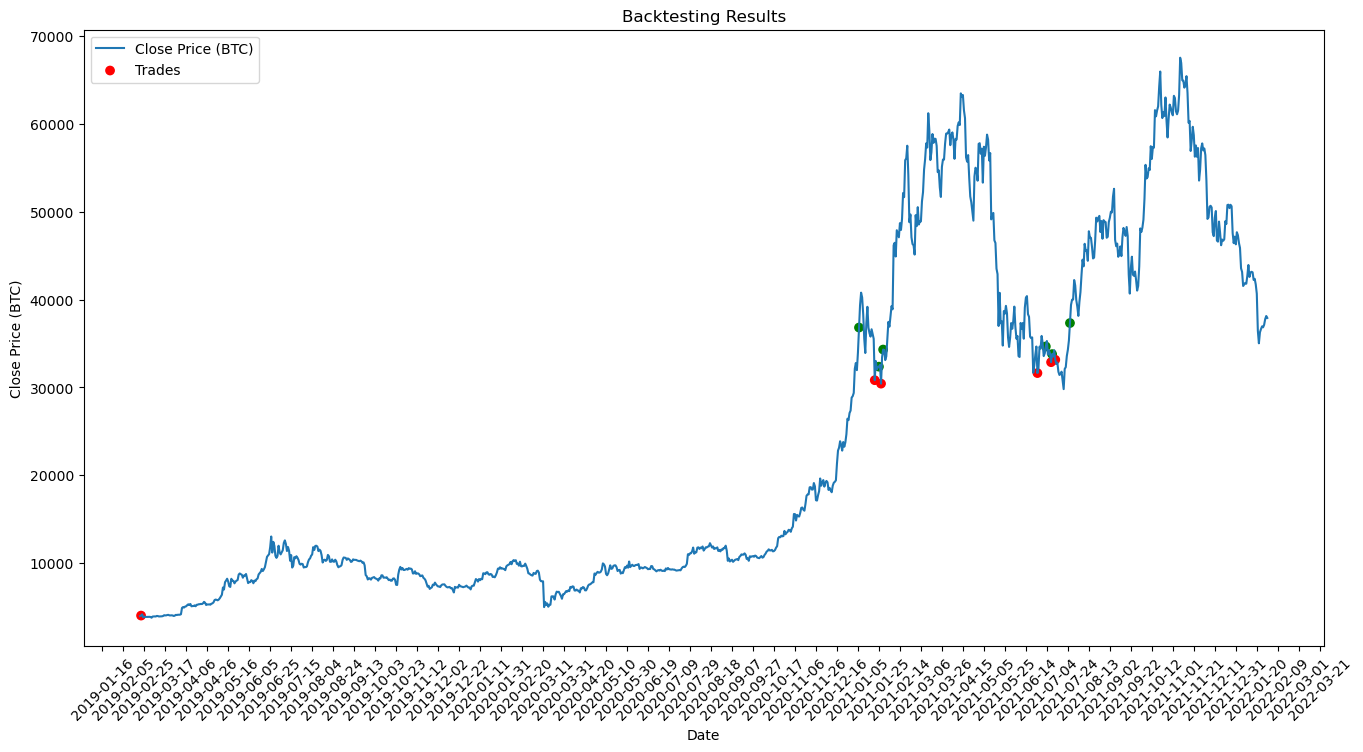

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe ratio.
    """
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
    return sharpe_ratio

def calculate_max_drawdown(balance_history):
    """
    Calculate the maximum drawdown.
    """
    cum_returns = np.cumsum(balance_history)
    if len(cum_returns) == 0:
        return 0

    peak = np.argmax(np.maximum.accumulate(cum_returns))
    trough = np.argmax(cum_returns[:peak])
    max_drawdown = (cum_returns[trough] - cum_returns[peak]) / cum_returns[peak] if peak != trough else 0
    return max_drawdown

def backtest(df, model, initial_balance=10000, transaction_cost_rate=0.0015, risk_free_rate=0):
    # Initialize variables
    balance = initial_balance
    position = 0  # 0: no position, 1: long position, -1: short position
    total_trades = 0
    winning_trades = 0
    losing_trades = 0
    trade_history = []
    balance_history = [initial_balance]

    # Separate features and target variable
    X = df[['Close_Log', 'RSI', 'MACD', 'Signal', 'Band_Width', 'Stochastic_Oscillator',
            'Volume_RoC', 'OBV', 'Volume_MA', 'BB_High', 'BB_Low', 'EMA', 'ROC',
            'VWAP', 'SMA_10', 'SMA_50']]
    y = df[['Target']]

    # Scale features using Min-Max scaling
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Reshape input data for LSTM
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Make predictions using the model
    predictions = model.predict(X_scaled)

    # Inverse transform the predicted values for the Target column
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1))

    # Iterate through historical data
    for i in range(1, len(df)):
        # Your trading strategy goes here
        # Example: Buy if LSTM predicts an increase, Sell if LSTM predicts a decrease

        # For illustration purposes, let's assume a simple strategy of buying and holding
        signal = 1 if predictions[i] > 0.5 else -1

        # Execute trades based on the signal
        if signal != position:
            # Calculate transaction cost
            transaction_cost = abs(signal - position) * transaction_cost_rate * df['Close (BTC)'].iloc[i]

            # Update balance
            balance -= transaction_cost

            # Record the trade in trade history
            trade_history.append({
                'Date': df['Date'].iloc[i],
                'Signal': 'Buy' if signal == 1 else 'Sell',
                'Price': df['Close (BTC)'].iloc[i],
                'Balance': balance
            })

            # Update position
            position = signal

            # Update trade counters
            total_trades += 1
            if signal == 1:
                winning_trades += 1
            else:
                losing_trades += 1

        # Record the balance at each time step
        balance_history.append(balance)

    # Calculate performance metrics
    returns = abs(balance - initial_balance) / initial_balance
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    sharpe_ratio = calculate_sharpe_ratio(np.array(balance_history), risk_free_rate)
    max_drawdown = calculate_max_drawdown(balance_history)

    # Display results
    print(f'Total Trades: {total_trades}')
    print(f'Winning Trades: {winning_trades}')
    print(f'Losing Trades: {losing_trades}')
    print(f'Win Rate: {win_rate:.2%}')
    print(f'Returns: {returns:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
    print(f'Maximum Drawdown: {max_drawdown:.2%}')

    # Visualize trade history
    '''trade_df = pd.DataFrame(trade_history)
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close (BTC)'], label='Close Price (BTC)')
    plt.scatter(trade_df['Date'], trade_df['Price'], c=trade_df['Signal'].map({'Buy': 'green', 'Sell': 'red'}),
                marker='o', label='Trades')
    plt.title('Backtesting Results')
    plt.xlabel('Date')
    plt.xticks(df['Date'][::5])
    plt.xticks(rotation=45)
    plt.ylabel('Close Price (BTC)')
    plt.legend()
    plt.show()'''
    trade_df = pd.DataFrame(trade_history)

    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    trade_df['Date'] = pd.to_datetime(trade_df['Date'])

    # Adjust figure size
    plt.figure(figsize=(16, 8))

    # Plotting
    plt.plot(df['Date'], df['Close (BTC)'], label='Close Price (BTC)')
    plt.scatter(trade_df['Date'], trade_df['Price'], c=trade_df['Signal'].map({'Buy': 'green', 'Sell': 'red'}),
                marker='o', label='Trades')

    # Formatting x-axis date labels
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=20))  # Adjust interval as needed

    # Title and labels
    plt.title('Backtesting Results')
    plt.xlabel('Date')
    plt.ylabel('Close Price (BTC)')

    # Legend and show
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


    return {
        'Total Trades': total_trades,
        'Winning Trades': winning_trades,
        'Losing Trades': losing_trades,
        'Win Rate': win_rate,
        'Returns': returns,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Trade History': trade_df
    }

# Apply backtesting
backtest_results = backtest(df, best_model)